In [1]:
# Load libraries.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime as dt
import re

import plotly.express as px

from pandas_datareader import data as pdr

import yfinance as yf

(
    yf
    .pdr_override()
)

import warnings
warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(230218)

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

from sklearn import linear_model

import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
class Backtest:
    def __init__(self,data, base_, tradingexp_):
        self.data=data
        self.base=base_
        self.tradingexp = tradingexp_
        ## Write any processing that needs to be done on the data
        self.data['Buy_Sell']= self.data['Position'] - self.data['Position'].shift(1)
        self.data['log_return']=np.log(self.data['Adj Close']/self.data['Adj Close'].shift(1))
        self.data['Strategy_return']=self.data['Position'].shift(1)*self.data['log_return']
        self.data['Expense']=np.where(abs(self.data['Buy_Sell'])> 0, self.tradingexp, 0)
        self.data['Capital']= self.base*self.data['Strategy_return'].cumsum().apply(np.exp)
        self.data['Adj Capital'] = self.base*self.data['Strategy_return'].cumsum().apply(np.exp) - self.data['Expense'].shift(1).cumsum()
        self.data['Adj return'] = np.log(self.data['Adj Capital']/self.data['Adj Capital'].shift(1))
        self.data['drawdown']=self.data['Adj return'].cumsum() - self.data['Adj return'].cumsum().cummax()

                
    def plot_backtest_buy_sell(self): 
        ax=\
        (
            self.data[['Adj Close',
                       'Position']]
            .plot(figsize=(18,8),
                  secondary_y=["Position"],
                  style=["red","b--"],
                  alpha=0.5
                 )
        )

        (
            ax.legend(loc="upper center"
                      ,shadow=True
                      ,fancybox=True
                      ,bbox_to_anchor=(0.55,1.10)
                      ,ncol=4
                     )
        )

        bx=\
        (
            self.data[self.data['Buy_Sell']>0]['Adj Close']
            .plot(style="g^",
                  markersize=12,
                  label='Buy')
        )

        bx.legend()

        cx=\
        (
            self.data[self.data['Buy_Sell']<0]['Adj Close']
            .plot(style="rv",
                  markersize=12,
                  label="Sell")
        )
        
        cx.legend()
        plt.title(f"Backtest Buy Sell Signals")
        plt.show()
      
    def calculate_cumm_return(self):
        res=100*(np.exp(self.data['Adj return'].sum()) -1)
        print(f"Cummulative return is: {res:.2f}% with final Account balance: ${self.data['Adj Capital'].iloc[-1]}")

    def calculate_max_drawdown(self):
        res=100* (np.exp(self.data['drawdown'].min()) - 1)
        print(f"Max Drawdown: {res:.2f}%")
    
    def calculate_max_drawdown_duration(self):
        periods =\
        self.data[self.data['drawdown'] == 0].index[ 1 :   ].to_pydatetime() \
        - self.data[self.data['drawdown'] == 0].index[   : -1].to_pydatetime()
        print(f"Max Drawdown Duration: {periods.max()}")

    def calculate_return_byyear(self):
        grpByYear=self.data.groupby(self.data.index.year)
        return grpByYear['Adj return'].sum().apply(np.exp) -1

    def calculate_sharpe_ratio(self):
        res = np.sqrt(252) * (self.data['Adj return'].dropna().apply(np.exp).add(-1).mean()) / (self.data['Adj return'].dropna().apply(np.exp).add(-1).std())
        print(f"Sharpe Ratio: {res:.3f}")

    def calculate_cagr(self):
        days =(self.data.index[-1] - self.data.index[0]).days
        CAGR =100*(((np.exp(self.data['Adj return'].sum()))**(365.0/days)) - 1)
        print(f"Strategy CAGR is: {CAGR:.2f}%")
        
    def plot_backtest_returns(self):
        ax =\
        (
            self.data[["log_return", "Adj return"]]
            .dropna()
            .cumsum()
            .apply(np.exp)
            .add(-1)
            .plot(figsize = [18, 7])
        )
        
        ax.set_title(f"Back Test Strategy vs Asset Return")
        ax.legend(["Asset Cumm Return","Strategy Cumm Return (Adj)"])
        bx =\
        (
            self.data['Adj return']
            .cumsum()
            .cummax()
            .apply(np.exp)
            .add(-1)
            .plot(ax=ax)
        )
        plt.show()
    
    def plot_all_stats(self):
        self.calculate_cumm_return()
        self.calculate_cagr()
        self.calculate_max_drawdown()
        self.calculate_sharpe_ratio()
        self.plot_backtest_returns()
        self.plot_backtest_buy_sell()

In [3]:
tickers=['^FHCI','SPY','^N225','^GDAXI','^HSI','^IXIC','AORD','SP500','DJI']
data = pdr.get_data_yahoo(tickers,start="2004-11-1", end="2023-11-1")
data

[*********************100%***********************]  9 of 9 completed

3 Failed downloads:
- AORD: No timezone found, symbol may be delisted
- ^FHCI: No timezone found, symbol may be delisted
- SP500: No timezone found, symbol may be delisted


Adj Close                                                      \
                AORD           DJI SP500         SPY ^FHCI        ^GDAXI   
Date                                                                       
2004-11-01       NaN  10054.400391   NaN   78.617920   NaN   4012.639893   
2004-11-02       NaN  10035.700195   NaN   78.645622   NaN   4037.570068   
2004-11-03       NaN  10137.000000   NaN   79.636070   NaN   4039.040039   
2004-11-04       NaN  10314.799805   NaN   80.723450   NaN   4041.379883   
2004-11-05       NaN  10387.500000   NaN   81.229111   NaN   4063.580078   
...              ...           ...   ...         ...   ...           ...   
2023-10-25       NaN           NaN   NaN  417.549988   NaN  14892.179688   
2023-10-26       NaN           NaN   NaN  412.549988   NaN  14731.049805   
2023-10-27       NaN           NaN   NaN  410.679993   NaN  14687.410156   
2023-10-30       NaN           NaN   NaN  415.589996   NaN  14716.540039   
2023-10-31       NaN           NaN   NaN  418.200012   NaN  14810.339844   

                                                     Close  ...          Open  \
                    ^HSI         ^IXIC         ^N225  AORD  ...         ^N225   
Date                                                        ...                 
2004-11-01  13094.250000   1979.869995  10734.709961   NaN  ...  10731.019531   
2004-11-02  13308.740234   1984.790039  10887.809570   NaN  ...  10775.000000   
2004-11-03  13397.669922   2004.329956           NaN   NaN  ...           NaN   
2004-11-04  13369.089844   2023.630005  10946.269531   NaN  ...  10990.700195   
2004-11-05  13494.950195   2038.939941  11061.769531   NaN  ...  11040.059570   
...                  ...           ...           ...   ...  ...           ...   
2023-10-25  17085.330078  12821.219727  31269.919922   NaN  ...  31302.509766   
2023-10-26  17044.609375  12595.610352  30601.779297   NaN  ...  30902.919922   
2023-10-27  17398.730469  12643.009766  30991.689453   NaN  ...  30713.789062   
2023-10-30  17406.359375  12789.480469  30696.960938   NaN  ...  30663.480469   
2023-10-31  17112.480469  12851.240234  30858.849609   NaN  ...  30694.960938   

           Volume                                                           \
             AORD  DJI SP500          SPY ^FHCI       ^GDAXI          ^HSI   
Date                                                                         
2004-11-01    NaN  0.0   NaN   36720900.0   NaN   65754300.0  1.984324e+08   
2004-11-02    NaN  0.0   NaN   56210000.0   NaN   88857800.0  3.862780e+08   
2004-11-03    NaN  0.0   NaN   76960200.0   NaN  112707800.0  3.527140e+08   
2004-11-04    NaN  0.0   NaN   55350300.0   NaN   85037600.0  3.084676e+08   
2004-11-05    NaN  0.0   NaN   63287200.0   NaN  123958100.0  3.623888e+08   
...           ...  ...   ...          ...   ...          ...           ...   
2023-10-25    NaN  NaN   NaN   94223200.0   NaN   88086100.0  2.499934e+09   
2023-10-26    NaN  NaN   NaN  115156800.0   NaN  121803600.0  1.967216e+09   
2023-10-27    NaN  NaN   NaN  107367700.0   NaN   86539200.0  2.452090e+09   
2023-10-30    NaN  NaN   NaN   86562700.0   NaN   76179000.0  2.665231e+09   
2023-10-31    NaN  NaN   NaN   79665200.0   NaN   75370200.0  2.112804e+09   

                                       
                   ^IXIC        ^N225  
Date                                   
2004-11-01  1.522820e+09   60400000.0  
2004-11-02  1.845080e+09   75600000.0  
2004-11-03  1.957400e+09          NaN  
2004-11-04  1.823490e+09   88000000.0  
2004-11-05  1.908970e+09   75300000.0  
...                  ...          ...  
2023-10-25  4.599850e+09   78700000.0  
2023-10-26  4.894900e+09   85600000.0  
2023-10-27  4.172100e+09   89100000.0  
2023-10-30  4.149320e+09  187000000.0  
2023-10-31  4.315630e+09  134300000.0  

[4945 rows x 54 columns]

In [4]:
data_xy=pd.DataFrame(index=data.index)

In [5]:
# data_xy['spy']=data.loc[:,('Open','SPY')].shift(-1)-data.loc[:,('Open','SPY')]
# data_xy['spy_lag1']=data_xy['spy'].shift(1)
# data_xy['nasdaq']=data.loc[:,('Open','^IXIC')]-data.loc[:,('Open','^IXIC')].shift(1)
# data_xy['dji']=data.loc[:,('Open','DJI')] - data.loc[:,('Open','DJI')].shift(1)
# data_xy['daxi']=data.loc[:,('Open','^GDAXI')] - data.loc[:,('Open','^GDAXI')].shift(1)
# data_xy['hsi']=data.loc[:,('Open','^HSI')] - data.loc[:,('Open','^HSI')].shift(1)
# data_xy['nikkei']=data.loc[:,('Open','^N225')] - data.loc[:,('Open','^N225')].shift(1)

# data_xy = data_xy.fillna(method='ffill')
# data_xy = data_xy.dropna()

# Train = data_xy.iloc[:-500, :]
# Test = data_xy.iloc[-500:, :]

# formula = 'spy~spy_lag1+nasdaq+dji+daxi+nikkei+hsi'
# lm = smf.ols(formula=formula, data=Train).fit()
# lm.summary()

# # Train['PredictedY'] = lm.predict(Train)
# # Test['PredictedY'] = lm.predict(Test)
# # plt.scatter(Train['spy'], Train['PredictedY'])

# # Train['Order'] = [1 if sig>0 else -1 for sig in Train['PredictedY']]
# # Train['Profit'] = Train['spy'] * Train['Order']
# # Train['Wealth'] = Train['Profit'].cumsum()
# # print('Total profit made in Train: ', Train['Profit'].sum())

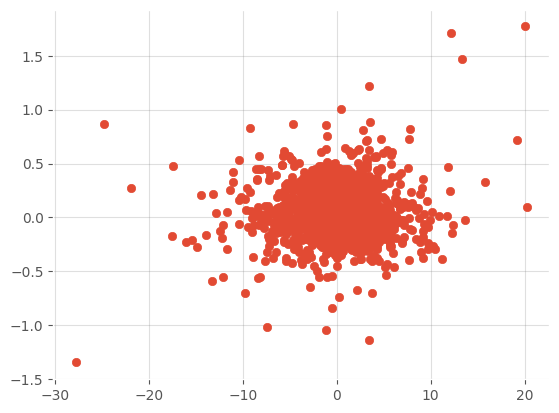

In [6]:
return_period=1
data_xy['spy']=data.loc[:,('Adj Close','SPY')].diff(return_period).shift(-return_period)
data_xy['spy_lag1']= data.loc[:,('Adj Close','SPY')].diff(return_period) ##data_xy['spy'].diff(return_period) ##
data_xy['nasdaq']=data.loc[:,('Adj Close','^IXIC')].diff(return_period)
data_xy['dji']=data.loc[:,('Adj Close','DJI')].diff(return_period)
data_xy['daxi']=data.loc[:,('Adj Close','^GDAXI')].diff(return_period)
data_xy['hsi']=data.loc[:,('Adj Close','^HSI')].diff(return_period)
data_xy['nikkei']=data.loc[:,('Adj Close','^N225')].diff(return_period)

data_xy = data_xy.fillna(method='ffill')
data_xy = data_xy.dropna()

Train = data_xy#.iloc[:-500, :]
#Test = data_xy.iloc[-500:, :]

formula = 'spy~spy_lag1+nasdaq+dji+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

Train['PredictedY'] = lm.predict(Train)
#Test['PredictedY'] = lm.predict(Test)
plt.scatter(Train['spy'], Train['PredictedY'])

Train['Order'] = [1 if sig>0 else -1 for sig in Train['PredictedY']]
#Test['Order'] = [1 if sig>0 else -1 for sig in Test['PredictedY']]

Cummulative return is: 1736.01% with final Account balance: $1859132.7235069443
Strategy CAGR is: 16.55%
Max Drawdown: -32.65%
Sharpe Ratio: 0.872


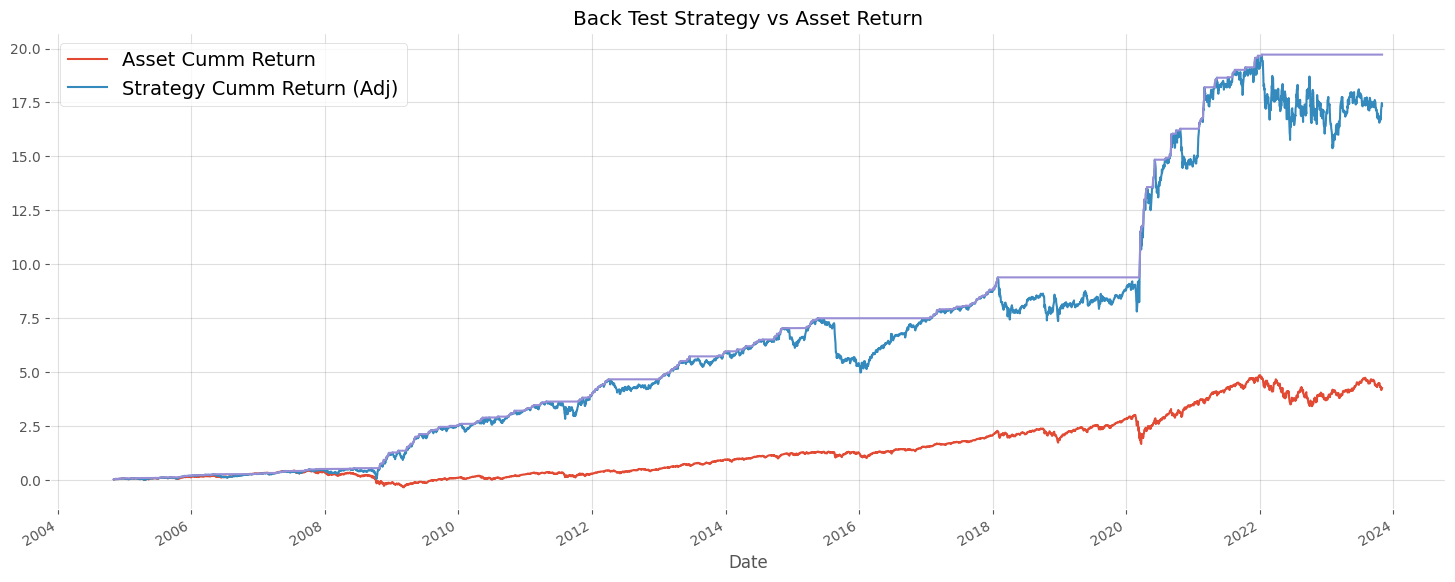

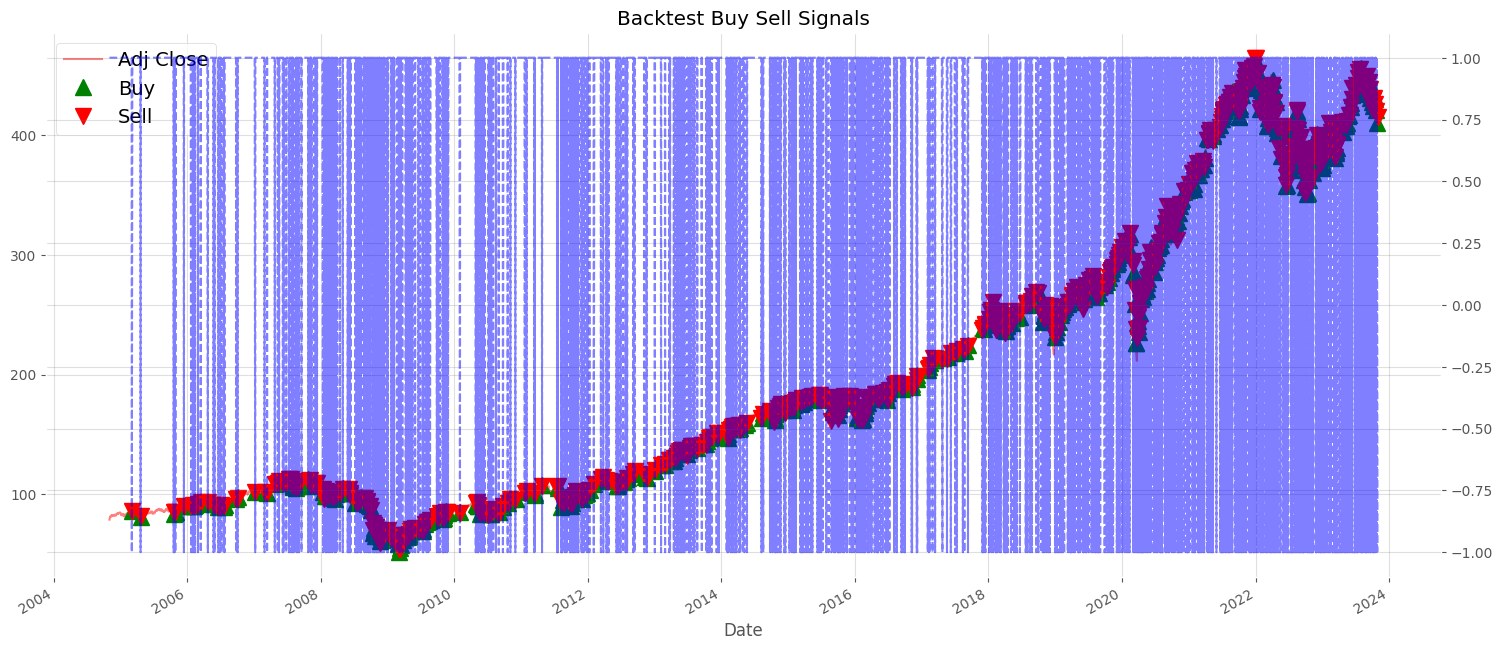

In [7]:
MR_data=data.loc[:,('Adj Close','SPY')]
MR_data.name='Adj Close'
MR_data=MR_data.to_frame()
MR_data=pd.concat([MR_data,Train['Order']],axis=1)
MR_data.columns=['Adj Close','Position']
MR_data=MR_data.fillna(method='ffill')
MR_data=MR_data.dropna()
Backtest_MR_Strategy=Backtest(MR_data,100000,0)
Backtest_MR_Strategy.plot_all_stats()

In [8]:
data_xy

,spy,spy_lag1,nasdaq,dji,daxi,hsi,nikkei,PredictedY,Order
Date,,,,,,,,,
2004-11-02,0.990448,0.027702,4.920044,-18.700195,24.930176,214.490234,153.099609,0.157262,1
2004-11-03,1.087379,0.990448,19.539917,101.299805,1.469971,88.929688,153.099609,0.073858,1
2004-11-04,0.505661,1.087379,19.300049,177.799805,2.339844,-28.580078,153.099609,0.041964,1
2004-11-05,-0.117798,0.505661,15.309937,72.700195,22.200195,125.860352,115.500000,0.098101,1
2004-11-08,-0.159279,-0.117798,0.310059,3.799805,5.389893,66.540039,-77.939453,0.096145,1
...,...,...,...,...,...,...,...,...,...
2023-10-25,-5.000000,-6.080017,-318.650391,596.402344,12.239258,93.800781,207.570312,-0.039644,-1
2023-10-26,-1.869995,-5.000000,-225.609375,596.402344,-161.129883,-40.720703,-668.140625,-0.162414,-1
2023-10-27,4.910004,-1.869995,47.399414,596.402344,-43.639648,354.121094,389.910156,0.291005,1


In [10]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.361
Date:                Sun, 19 Nov 2023   Prob (F-statistic):            0.00262
Time:                        19:42:31   Log-Likelihood:                -11483.
No. Observations:                4944   AIC:                         2.298e+04
Df Residuals:                    4937   BIC:                         2.303e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1102      0.037      3.013      0.003       0.038       0.182
spy_lag1      -0.0822      0.046     -1.796      0.073      -0.172       0.008
nasdaq         0.0017      0.001      1.533      0.125      -0.000       0.004
dji           -0.0003      0.000     -1.726      0.084      -0.001    4.01e-05
daxi          -0.0003      0.000     -0.887      0.375      -0.001       0.000
nikkei         0.0003      0.000      1.588      0.112   -6.53e-05       0.001
hsi         5.394e-06      0.000      0.041      0.967      -0.000       0.000
==============================================================================
Omnibus:                     1448.823   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46661.491
Skew:                          -0.755   Prob(JB):                         0.00
Kurtosis:                      17.974   Cond. No.                         447.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:


#1 get the data (in dataframes) and set the Date as index 

cac40=pd.read_csv("^FCHI.csv")
spy=pd.read_csv("SPY.csv")
nikkei=pd.read_csv("^N225.csv")
daxi=pd.read_csv("^GDAXI.csv")
hsi=pd.read_csv("^HSI.csv")
nasdaq=pd.read_csv("^IXIC.csv")
aord = pd.read_csv("AORD.csv")
sp500 = pd.read_csv("SP500.csv")
dji = pd.readcsv("DJI.csv")

spy.set_index(spy["Date"],inplace=True)
cac40.set_index(cac40["Date"],inplace=True)
nikkei.set_index(nikkei["Date"], inplace=True)
daxi.set_index(daxi["Date"],inplace=True)
hsi.set_index(hsi["Date"],inplace=True)
nasdaq.set_index(nasdaq["Date"],inplace=True)
aord.set_index(aord["Date"],inplace=True)
sp500.set_index(sp500["Date"],inplace=True)
dji.set_index(dji["Date"],inplace=True)

#2 Extract the data from each DF into one : We
indicepanel=pd.DataFrame(index=spy.index)

indicepanel['spy']=spy['Open'].shift(-1)-spy['Open'] #response variable
indicepanel['spy_lag1']=indicepanel['spy'].shift(1)
indicepanel['sp500']=sp500["Open"]-sp500['Open'].shift(1)
indicepanel['nasdaq']=nasdaq['Open']-nasdaq['Open'].shift(1)
indicepanel['dji']=dji['Open']-dji['Open'].shift(1)

indicepanel['cac40']=cac40['Open']-cac40['Open'].shift(1)
indicepanel['daxi']=daxi['Open']-daxi['Open'].shift(1)

indicepanel['aord']=aord['Close']-aord['Open']
indicepanel['hsi']=hsi['Close']-hsi['Open']
indicepanel['nikkei']=nikkei['Close']-nikkei['Open']
indicepanel['Price']=spy['Open']

#3 get rid of the NaN values

indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

#4 let's split the Data set into train and test.

Train = indicepanel.iloc[-2000:-1000, :]
Test = indicepanel.iloc[-1000:, :]
print(Train.shape, Test.shape)

#5 perform the OLS regression 

formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

#6 Prediction 

Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)
plt.scatter(Train['spy'], Train['PredictedY'])

#7 check statistical validity

from funcmod import assessTable,Adjustedmetric
assessTable(Test, Train, lm, 9, 'spy')

#8 Signal Based strat profits

# Train
Train['Order'] = [1 if sig>0 else -1 for sig in Train['PredictedY']]
Train['Profit'] = Train['spy'] * Train['Order']
Train['Wealth'] = Train['Profit'].cumsum()
print('Total profit made in Train: ', Train['Profit'].sum())

# Plot
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(Train['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Train['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

# Test
Test['Order'] = [1 if sig>0 else -1 for sig in Test['PredictedY']]
Test['Profit'] = Test['spy'] * Test['Order']
Test['Wealth'] = Test['Profit'].cumsum()
print('Total profit made in Test: ', Test['Profit'].sum())

# Plot
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(Test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Test['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

#9 Sharpe Ratio and Maximum Drawdown

Train['Wealth'] = Train['Wealth'] + Train.loc[Train.index[0], 'Price']
Test['Wealth'] = Test['Wealth'] + Test.loc[Test.index[0], 'Price']

# Sharpe Ratio on Train data
Train['Return'] = np.log(Train['Wealth']) - np.log(Train['Wealth'].shift(1))
dailyr = Train['Return'].dropna()
print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

# Sharpe Ratio in Test data
Test['Return'] = np.log(Test['Wealth']) - np.log(Test['Wealth'].shift(1))
dailyr = Test['Return'].dropna()
print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

# Maximum Drawdown in Train data
Train['Peak'] = Train['Wealth'].cummax()
Train['Drawdown'] = (Train['Peak'] - Train['Wealth'])/Train['Peak']
print('Maximum Drawdown in Train is ', Train['Drawdown'].max())

# Maximum Drawdown in Test data
Test['Peak'] = Test['Wealth'].cummax()
Test['Drawdown'] = (Test['Peak'] - Test['Wealth'])/Test['Peak']
print('Maximum Drawdown in Test is ', Test['Drawdown'].max())

FileNotFoundError: [Errno 2] No such file or directory: '^FCHI.csv'

In [ ]:
#Py file to have the function ready for any other model 

import pandas as pd

def adjustedMetric(data, model, model_k, yname):
    data["yhat"] = model.predict(data)
    SST = ((data[yname] - data[yname].mean()) ** 2).sum()
    SSR = ((data["yhat"] - data[yname].mean()) ** 2).sum()
    SSE = ((data[yname] - data["yhat"]) ** 2).sum()
    r2 = SSR / SST
    adjustR2 = 1 - (1 - r2) * (data.shape[0] - 1) / (data.shape[0] - model_k - 1)
    RMSE = (SSE / (data.shape[0] - model_k - 1)) ** 0.5
    return adjustR2, RMSE
# Root Mean Squared Error and Adjusted R2
# model_k is the number of predictors
# ynam is the column name of our response variable
# model is the model name here lm


def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=["R2", "RMSE"], columns=["train", "test"])
    assessment["train"] = [r2train, RMSEtrain]
    assessment["test"] = [r2test, RMSEtest]
    return assessment